In [3]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from scipy import linalg

In [15]:
def test(img_reference,frame):

	sift = cv2.SIFT_create()
	kp_reference, des_reference = sift.detectAndCompute(img_reference,None)
	kp_frame, des_frame = sift.detectAndCompute(frame,None)
	bf = cv2.BFMatcher()
	matches = bf.knnMatch(des_reference,des_frame, k=2)

	correspondence_reference = []
	correspondence_frame = []
	for m,n in matches:
		if m.distance < 0.5*n.distance:
			correspondence_reference.append(kp_reference[m.queryIdx].pt)
			correspondence_frame.append(kp_frame[m.trainIdx].pt)

	A = np.empty((0,9))
	for i in range(len(correspondence_reference)):
		u,v=correspondence_frame[i]
		x,y=correspondence_reference[i]

		x=np.array([
				   [-x , -y , -1 , 0 ,0 ,0 ,u*x, u*y , u],
				   [0,0,0,-x,-y,-1,v*x,v*y,v]
				   ])

		A = np.vstack( (A,x) )

	u, s, v = linalg.svd(A)
	DOF=np.reshape(v[np.argmin(s)],(3,3))

	temp_frame=np.zeros((img_reference.shape[0]+frame.shape[0],img_reference.shape[1]+frame.shape[1]))
	#temp_frame=frame.copy()
	for i in range (img_reference.shape[0]):
		for j in range (img_reference.shape[1]):
				res=np.matmul(DOF,(j,i, 1))
				res=np.ceil(res/res[2]).astype(int)
				temp_frame[i+int(img_reference.shape[0]/2),j+int(img_reference.shape[1]/2)]=frame[i,j]
				temp_frame[res[1]+int(img_reference.shape[0]/2),res[0]+int(img_reference.shape[1]/2)]=img_reference[i,j]

	y_nonzero, x_nonzero= np.nonzero(temp_frame)
	x=temp_frame[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

	return x

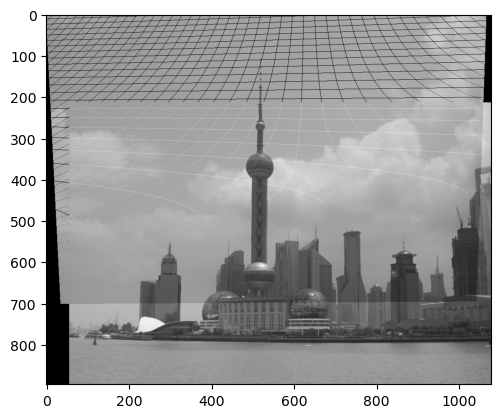

In [16]:
img_reference = cv2.imread("shanghai-22.png",0)
frame=cv2.imread("shanghai-21.png",0)
x=test(img_reference,frame)
plt.imshow(x, cmap='gray', vmin=0, vmax=255)

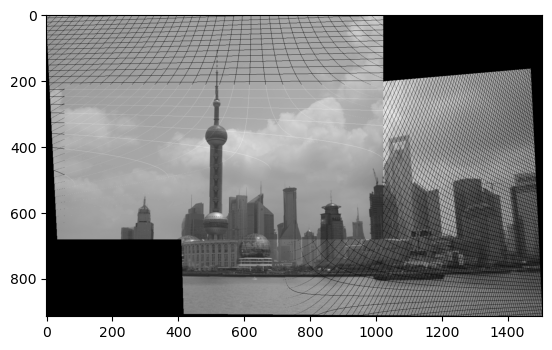

In [17]:
img_reference = cv2.imread("shanghai-23.png",0)
frame=cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
x=test(img_reference,frame)
plt.imshow(x, cmap='gray', vmin=0, vmax=255)

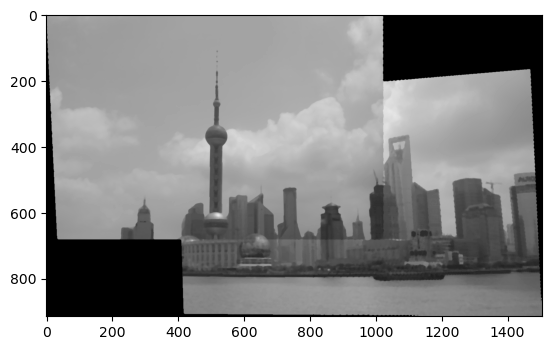

In [23]:
from scipy import ndimage, misc
result = ndimage.median_filter(x, size=7)
plt.imshow(result, cmap='gray', vmin=0, vmax=255)